In [358]:
import sys, os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_directory = '/Users/user/Projects/allee_effect/data'
results_directory = '/Users/user/Projects/allee_effect/results/'

def findVals(path, df=None):
    dfStart = 'Results'
    dfDate = ''
    dfTime = ''
    with open(path, 'rt', encoding = 'utf-8', errors='replace') as f:
        if df is None:
            for num, line in enumerate(f, 1):
                if dfStart in line:
                    return num
        for line in f:
            if 'Date' in line:
                dfDate = line.split('\t')[-1].strip('\n')
            if 'Time' in line:
                dfTime = line.split('\t')[-1].strip('\n')
                    
    dT = ', '.join((dfDate, dfTime))
    return dT

def addMultiIndex(df, dT):
    tempDf = df.copy()
    tempColumns = tempDf.columns
    newColumns = []
    
    for i in tempColumns:
        if i <= 6:
            newColumns.append((dT, 'MR', i))
        elif i > 6:
            newColumns.append((dT, 'MVF', i))
            
    return newColumns
    
def elapsedTime(dT):
    dateTimeObj = []
    elapsedTime = []
    for timePoint in dT:
        tempDt = datetime.strptime(timePoint, '%m/%d/%Y, %I:%M:%S %p')
        dateTimeObj.append(tempDt)
        
    zeroPoint = min(dateTimeObj)
    
    for i in range(len(dateTimeObj)):
        elapsed = round((((dateTimeObj[i] - zeroPoint).total_seconds())/3600), 2)
        elapsedTime.append((dT[i], elapsed))
    
    return elapsedTime
    
def preprocess(data_directory):
    reads_dfs = []
    dateAndTime = []

    for dirName, subdirList, fileList in os.walk(data_directory):
        for fname in fileList:
            extension = fname.split('.')[-1]
            if extension == 'txt':
                path = os.path.join(data_directory, fname)

                df = pd.read_csv(path, skiprows=findVals(path), sep='\t', header=0, index_col=0)
                df.columns = (range(1, df.shape[1]+1))
                df = df.drop(df.columns[-1], axis=1)
                #Reindexed [A,      B,     C,     D,      E,      F,      G,       H]
                df.index = ['1:2', '1:4', '1:8', '1:16', '1:32', '1:64', '1:128', 'Control']
                
                dfDateTime = findVals(path, df)
                dateAndTime.append(dfDateTime)

                df.columns = pd.MultiIndex.from_tuples(addMultiIndex(df, dfDateTime), names=['Date', 'Strain', 'Replicate'])
                reads_dfs.append(df)

    odVals = pd.concat(reads_dfs, axis=1)
    
    return odVals, dateAndTime

def plotDilution(df, times, strain='MR', row='Control', plotDil=True, color='b'):
    dilutionsDf = []
    
    for n in range(1,7):
        x = []
        y = []
        
        for t in elapsedTimes:
            x.append(t[-1])
            if strain == 'MR':
                y.append(odVals.loc[row,(t[0], strain, n)])
            elif strain == 'MVF':
                y.append(odVals.loc[row,(t[0], strain, n+6)])
        
        order = np.argsort(x)
        x = np.array(x)[order]
        y = np.array(y)[order]
        
        tempSeries = pd.Series(y, index=x)
        dilutionsDf.append(tempSeries)
        
    dilutions = pd.concat(dilutionsDf, axis=1)
    dilutions.columns = range(1,7)
    
    if plotDil == True:
        plt.style.use('seaborn-darkgrid')
#         palette = plt.get_cmap('Set1')
#         colorNum = 0
        
        for column in dilutions.columns:
            #colorNum+=1
            tempX = dilutions.index
            plt.plot(tempX, dilutions[column], color=color, linewidth=1, alpha=0.9)

        plt.title('Growth over time for {} replicate in dilution {}'.format(strain, row))
        plt.xlabel('Time (hours)')
        plt.ylabel('OD')
        plt.ylim(0, max(df.values.flatten()))
    
    return dilutions

def plotStrain(df, times, strain='MR', plotAll=False):
    strainDf = []
    colorNum=0
    
    for row in df.index:
        if plotAll == True:
            colorNum+=1
            palette = plt.get_cmap('Set1')
            dilDf = plotDilution(df, times, strain=strain, row=row, plotDil=True, color=palette(colorNum))
        else:
            dilDf = plotDilution(df, times, strain=strain, row=row, plotDil=False)
            dilDf = dilDf.mean(axis=1)
            
        
        strainDf.append(dilDf)
    
    strainDf = pd.concat(strainDf, axis=1, keys = df.index)
    
    if plotAll == False:
        plt.style.use('seaborn-darkgrid')
        palette = plt.get_cmap('Set1')
        colorNum = 0

        for column in strainDf.columns:
            colorNum+=1
            tempX = strainDf.index
            plt.plot(tempX, strainDf[column], color=palette(colorNum), linewidth=1, alpha=0.9, label=column)

        plt.title('Average Growth over time for relpicates of {} strain'.format(strain))
        plt.xlabel('Time (hours)')
        plt.ylabel('OD')
        plt.legend(loc=2, ncol=2)
        plt.ylim(0, max(df.values.flatten()))
    
    return strainDf

def jakesODVals(df, elapsedTimes):
    formattedDf = pd.DataFrame(np.zeros((len(df.values.flatten()),6)))
    formattedDf.columns = ('Dilution', 'Date', 'Elapsed Time', 'Strain', 'Replicate', 'OD')
    
    row = 0
    
    for time, strain, rep in df.columns:
        for dilution in df.index:
            timeLoc = [i for i, j in enumerate(elapsedTimes) if j[0] == time]
            
            formattedDf.loc[row, 'Dilution'] = dilution
            formattedDf.loc[row, 'Date'] = time
            formattedDf.loc[row, 'Elapsed Time'] = elapsedTimes[timeLoc[0]][1]
            formattedDf.loc[row, 'Strain'] = strain
            formattedDf.loc[row, 'Replicate'] = str(rep)
            formattedDf.loc[row, 'OD'] = df.loc[dilution, (time, strain, rep)]
            
            row+=1
        
    return formattedDf

In [359]:
odVals, dateAndTime = preprocess(data_directory)
odVals.loc['1:4', ('8/9/2019, 9:52:50 AM', 'MR', 6)] = np.NaN
elapsedTimes = elapsedTime(dateAndTime)

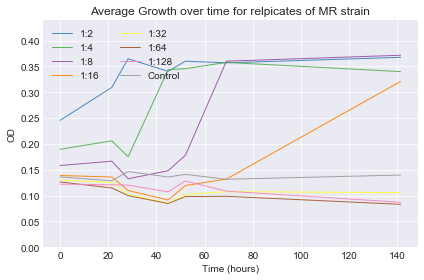

In [362]:
meansDf = plotStrain(odVals, elapsedTimes, strain='MR', plotAll=False)

# figureName = results_directory+'mean_MR_dilutions.pdf'
# plt.tight_layout()
# plt.savefig(figureName)

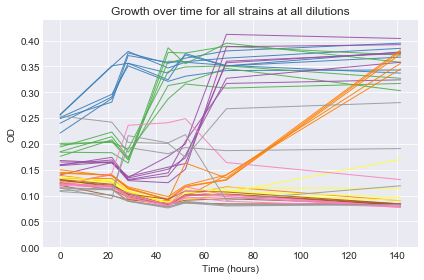

In [363]:
alls = plotStrain(odVals, elapsedTimes, strain='MR', plotAll=True)
plt.title('Growth over time for all strains at all dilutions')

# figureName = results_directory+'all_dilutions.pdf'
# plt.tight_layout()
# plt.savefig(figureName)

In [365]:
# jakesDf = jakesODVals(odVals, elapsedTimes)
# export_csv = jakesDf.to_csv(os.path.join(results_directory, 'formattedDf.csv'), sep='\t')